In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
import re
import unicodedata
import pandas as pd
import json

In [221]:
# read tsv with headers
with open("./exports/crowd_data.tsv", "r") as f:
    crowd_df = pd.read_csv(f, sep="\t", index_col="AssignmentId")
    crowd_df = crowd_df.sort_values(by=["HITId", "HITTypeId", "WorkerId"])

crowd_df

,HITId,HITTypeId,Title,Reward,WorkerId,AssignmentStatus,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
AssignmentId,,,,,,,,,,,,,,,
4,1,7QT,Is this triple correct or incorrect?,$0.50,1726JMZQW,Submitted,80,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
1,1,7QT,Is this triple correct or incorrect?,$0.50,2133ICYWE97,Submitted,60,99%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
2,1,7QT,Is this triple correct or incorrect?,$0.50,2133U7HKDLO,Submitted,40,40%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,yes,yes
5,1,7QT,Is this triple correct or incorrect?,$0.50,2134U7HKDMM,Submitted,2,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
3,1,7QT,Is this triple correct or incorrect?,$0.50,928UJANWZ12,Submitted,50,98%,wd:Q11621,wdt:P2142,792910554,2.0,INCORRECT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,61,9QT,Is this triple correct or incorrect?,$0.50,AALKMII97,Submitted,240,98%,wd:Q1288004,wdt:P1412,wd:Q13330,2.0,INCORRECT,Object,Q1860
303,61,9QT,Is this triple correct or incorrect?,$0.50,GGUI83657S,Submitted,120,85%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN
302,61,9QT,Is this triple correct or incorrect?,$0.50,HHCKW1111,Submitted,200,80%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN


In [222]:
crowd_df = crowd_df.drop(columns=["Title", "Reward", "AssignmentStatus"])
crowd_df

,HITId,HITTypeId,WorkerId,WorkTimeInSeconds,LifetimeApprovalRate,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
AssignmentId,,,,,,,,,,,,
4,1,7QT,1726JMZQW,80,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
1,1,7QT,2133ICYWE97,60,99%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
2,1,7QT,2133U7HKDLO,40,40%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,yes,yes
5,1,7QT,2134U7HKDMM,2,70%,wd:Q11621,wdt:P2142,792910554,1.0,CORRECT,NaN,NaN
3,1,7QT,928UJANWZ12,50,98%,wd:Q11621,wdt:P2142,792910554,2.0,INCORRECT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
301,61,9QT,AALKMII97,240,98%,wd:Q1288004,wdt:P1412,wd:Q13330,2.0,INCORRECT,Object,Q1860
303,61,9QT,GGUI83657S,120,85%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN
302,61,9QT,HHCKW1111,200,80%,wd:Q1288004,wdt:P1412,wd:Q13330,1.0,CORRECT,NaN,NaN


In [223]:
crowd_df['LifetimeApprovalRate'] = crowd_df['LifetimeApprovalRate'].astype(str).str.rstrip('%').astype('float') / 100
crowd_df['WorkTimeInSeconds'] = crowd_df['WorkTimeInSeconds'].astype(float)


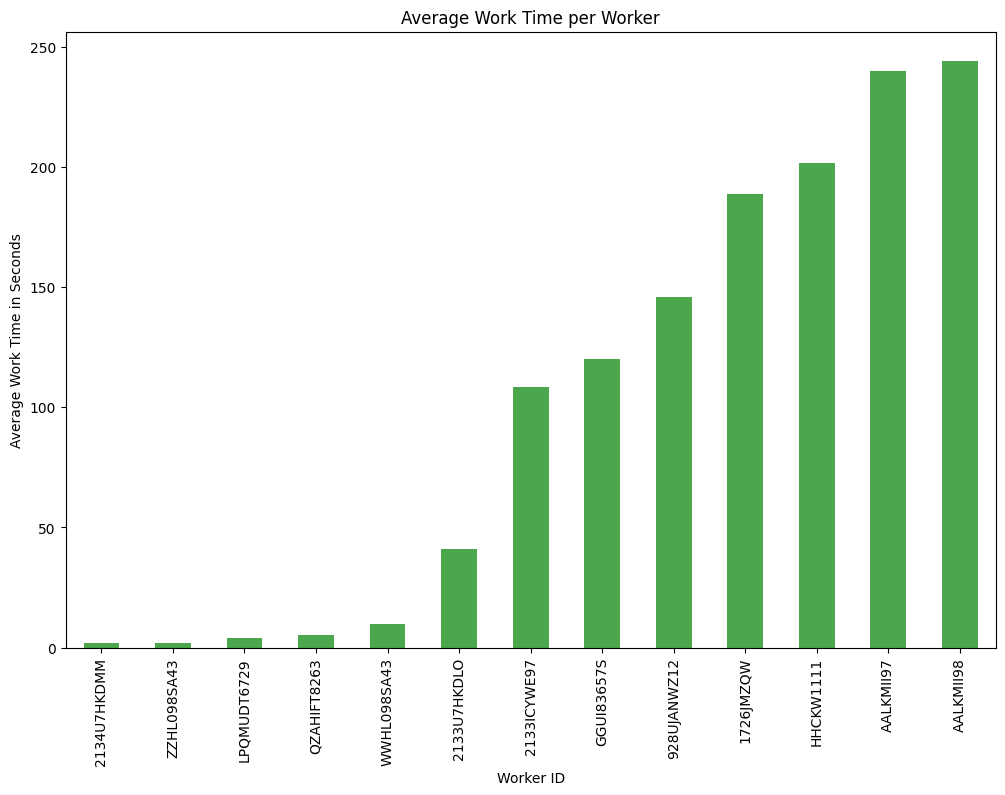

In [224]:
average_work_time_per_worker = crowd_df.groupby('WorkerId')['WorkTimeInSeconds'].mean().sort_values(ascending=True)

plt.figure(figsize=(12, 8))
average_work_time_per_worker.plot(kind='bar', color='green', alpha=0.7)
plt.title('Average Work Time per Worker')
plt.xlabel('Worker ID')
plt.ylabel('Average Work Time in Seconds')
plt.xticks(rotation=90)
plt.show()

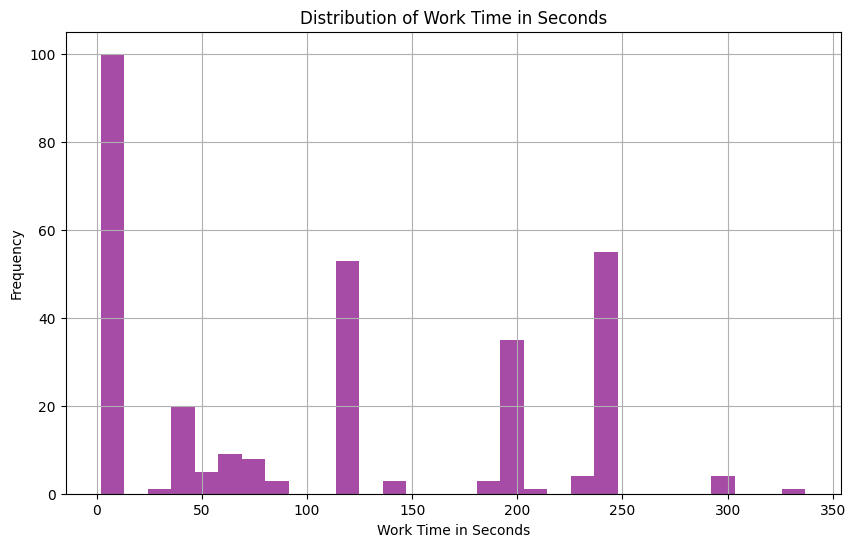

In [225]:
plt.figure(figsize=(10, 6))
plt.hist(crowd_df['WorkTimeInSeconds'], bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Work Time in Seconds')
plt.xlabel('Work Time in Seconds')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

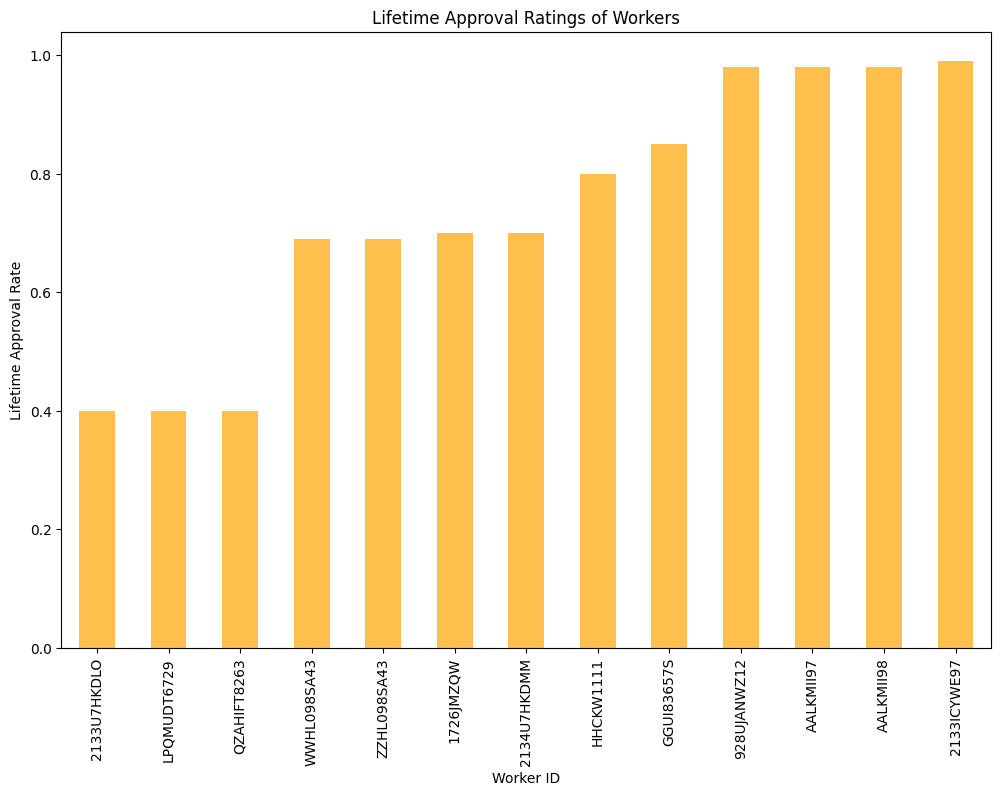

In [226]:
# Plotting the Lifetime Approval Rate for each worker
worker_ratings = crowd_df.groupby('WorkerId')['LifetimeApprovalRate'].mean().sort_values(ascending=True)
plt.figure(figsize=(12, 8))
worker_ratings.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Lifetime Approval Ratings of Workers')
plt.xlabel('Worker ID')
plt.ylabel('Lifetime Approval Rate')
plt.xticks(rotation=90)
plt.show()

In [227]:
crowd_data = crowd_df[crowd_df['LifetimeApprovalRate'] >= 0.5]

In [228]:
# Calculating the average work time for each worker
average_work_time = crowd_data.groupby('WorkerId')['WorkTimeInSeconds'].mean()
workers_to_remove = average_work_time[average_work_time < 35].index
crowd_data = crowd_data[~crowd_data['WorkerId'].isin(workers_to_remove)]

In [229]:
tasks_solved_quickly = crowd_data[crowd_data['WorkTimeInSeconds'] < 10]

In [230]:
crowd_df = crowd_df.drop(columns=["WorkTimeInSeconds", "LifetimeApprovalRate"])

In [231]:
json_files = ["./exports/people_db.json", "./exports/movie_db.json"]
merged_data = {
    k.split("/")[-1]: v
    for file_path in json_files
    for k, v in json.load(open(file_path, 'r')).items()
}

with open("./exports/predicate_db.json", 'r') as f:
    # Reversed index
    merged_data.update({v.split("/")[-1]: k for k, v in json.load(f).items()})

def set_label(value, required=True):
    value = str(value)
    if "/" in value:
        value = value.split("/")[-1]
    elif ":" in value:
        value = value.split(":")[-1]
    return merged_data.get(value, np.nan if required else value)

for column in ["Input1ID", "Input2ID"]:
    crowd_df[column] = crowd_df[column].apply(set_label, required=True)

for column in ["Input3ID", "FixValue"]:
    crowd_df[column] = crowd_df[column].apply(set_label, required=False)


crowd_df = crowd_df.dropna(subset=["Input1ID", "Input2ID", "Input3ID"])

crowd_df


,HITId,HITTypeId,WorkerId,Input1ID,Input2ID,Input3ID,AnswerID,AnswerLabel,FixPosition,FixValue
AssignmentId,,,,,,,,,,
4,1,7QT,1726JMZQW,et the extraterrestrial,box office,792910554,1.0,CORRECT,NaN,nan
1,1,7QT,2133ICYWE97,et the extraterrestrial,box office,792910554,1.0,CORRECT,NaN,nan
2,1,7QT,2133U7HKDLO,et the extraterrestrial,box office,792910554,1.0,CORRECT,yes,yes
5,1,7QT,2134U7HKDMM,et the extraterrestrial,box office,792910554,1.0,CORRECT,NaN,nan
3,1,7QT,928UJANWZ12,et the extraterrestrial,box office,792910554,2.0,INCORRECT,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
301,61,9QT,AALKMII97,nat pendleton,languages spoken written or signed,Q13330,2.0,INCORRECT,Object,Q1860
303,61,9QT,GGUI83657S,nat pendleton,languages spoken written or signed,Q13330,1.0,CORRECT,NaN,nan
302,61,9QT,HHCKW1111,nat pendleton,languages spoken written or signed,Q13330,1.0,CORRECT,NaN,nan


In [232]:
result = (
    crowd_df.groupby(["Input1ID", "Input2ID", "Input3ID", "HITTypeId", "HITId"])
    .agg(
        Votes_CORRECT=("AnswerLabel", lambda x: (x == "CORRECT").sum()),
        Votes_INCORRECT=("AnswerLabel", lambda x: (x == "INCORRECT").sum()),
        Corrections_Subject=("FixValue", lambda x: x[crowd_df["FixPosition"] == "Subject"].tolist()),
        Corrections_Predicate=("FixValue", lambda x: x[crowd_df["FixPosition"] == "Predicate"].tolist()),
        Corrections_Object=("FixValue", lambda x: x[crowd_df["FixPosition"] == "Object"].tolist()),
    )
    .reset_index()
)

def ensure_single_value(corrections):
    unique_values = list(set([v for v in corrections if pd.notna(v) and v != "nan"]))
    if len(unique_values) > 1:
        raise ValueError(f"Multiple values found where a single value is expected: {unique_values}")
    return unique_values[0] if unique_values else np.nan

result["Corrections_Subject"] = result["Corrections_Subject"].apply(ensure_single_value)
result["Corrections_Predicate"] = result["Corrections_Predicate"].apply(ensure_single_value)
result["Corrections_Object"] = result["Corrections_Object"].apply(ensure_single_value)


def handle_nan_subject(row):
    """ If subject is wrong, then it is easier to swap the statement and correct the object """
    if not pd.isna(row["Corrections_Subject"]):
        row["Input1ID"], row["Input3ID"] = row["Input3ID"], row["Input1ID"]
        row["Corrections_Object"] = row["Corrections_Subject"]
        row["Corrections_Subject"] = np.nan
    return row

result = result.apply(handle_nan_subject, axis=1)

if not result["Corrections_Subject"].isna().all():
    raise Exception("Not all corrections have been handled")

result = result.drop(columns=["Corrections_Subject"])

result

,Input1ID,Input2ID,Input3ID,HITTypeId,HITId,Votes_CORRECT,Votes_INCORRECT,Corrections_Predicate,Corrections_Object
0,a happy event,cast member,theis schmidt,9QT,44,0,5,NaN,erika sainte
1,a night at the opera,cast member,jude law,9QT,58,1,4,NaN,rolfe sedan
2,william hurt,cast member,behind the candelabra,8QT,32,2,3,NaN,the blue butterfly
3,frederick worlock,cast member,bloody mama,8QT,38,2,3,NaN,airport
4,cho geunhyeon,country of citizenship,Q916,9QT,60,2,3,NaN,Q884
5,conan the barbarian,voice actor,rose mcgowan,8QT,41,2,3,cast member,NaN
6,eskimo,production designer,john lee mahin,9QT,43,1,4,screenwriter,NaN
7,et the extraterrestrial,box office,792910554,7QT,1,4,1,NaN,NaN
8,finding nemo,box office,969023261,7QT,4,2,3,NaN,NaN
9,free willy 3 the rescue,screenwriter,angel de andres miquel,9QT,45,2,3,NaN,keith walker


In [233]:
result.dropna(subset=["Corrections_Predicate", "Corrections_Object"])
result

,Input1ID,Input2ID,Input3ID,HITTypeId,HITId,Votes_CORRECT,Votes_INCORRECT,Corrections_Predicate,Corrections_Object
0,a happy event,cast member,theis schmidt,9QT,44,0,5,NaN,erika sainte
1,a night at the opera,cast member,jude law,9QT,58,1,4,NaN,rolfe sedan
2,william hurt,cast member,behind the candelabra,8QT,32,2,3,NaN,the blue butterfly
3,frederick worlock,cast member,bloody mama,8QT,38,2,3,NaN,airport
4,cho geunhyeon,country of citizenship,Q916,9QT,60,2,3,NaN,Q884
5,conan the barbarian,voice actor,rose mcgowan,8QT,41,2,3,cast member,NaN
6,eskimo,production designer,john lee mahin,9QT,43,1,4,screenwriter,NaN
7,et the extraterrestrial,box office,792910554,7QT,1,4,1,NaN,NaN
8,finding nemo,box office,969023261,7QT,4,2,3,NaN,NaN
9,free willy 3 the rescue,screenwriter,angel de andres miquel,9QT,45,2,3,NaN,keith walker


In [234]:
contingency_tables_latest = result.groupby(['HITTypeId', 'HITId'])[['Votes_CORRECT', 'Votes_INCORRECT']].sum()

fleiss_kappa_per_batch = contingency_tables_latest.groupby(level=0).apply(fleiss_kappa)

kappa_mapping = fleiss_kappa_per_batch.to_dict()

result['HITTypeId'] = result['HITTypeId'].map(kappa_mapping)

result

,Input1ID,Input2ID,Input3ID,HITTypeId,HITId,Votes_CORRECT,Votes_INCORRECT,Corrections_Predicate,Corrections_Object
0,a happy event,cast member,theis schmidt,-0.012500,44,0,5,NaN,erika sainte
1,a night at the opera,cast member,jude law,-0.012500,58,1,4,NaN,rolfe sedan
2,william hurt,cast member,behind the candelabra,0.145192,32,2,3,NaN,the blue butterfly
3,frederick worlock,cast member,bloody mama,0.145192,38,2,3,NaN,airport
4,cho geunhyeon,country of citizenship,Q916,-0.012500,60,2,3,NaN,Q884
5,conan the barbarian,voice actor,rose mcgowan,0.145192,41,2,3,cast member,NaN
6,eskimo,production designer,john lee mahin,-0.012500,43,1,4,screenwriter,NaN
7,et the extraterrestrial,box office,792910554,-0.108374,1,4,1,NaN,NaN
8,finding nemo,box office,969023261,-0.108374,4,2,3,NaN,NaN
9,free willy 3 the rescue,screenwriter,angel de andres miquel,-0.012500,45,2,3,NaN,keith walker


In [235]:
result.replace("NaN", np.nan, inplace=True)
filtered_result = result.dropna(subset=["Corrections_Predicate", "Corrections_Object"], how='all')
filtered_result

,Input1ID,Input2ID,Input3ID,HITTypeId,HITId,Votes_CORRECT,Votes_INCORRECT,Corrections_Predicate,Corrections_Object
0,a happy event,cast member,theis schmidt,-0.012500,44,0,5,NaN,erika sainte
1,a night at the opera,cast member,jude law,-0.012500,58,1,4,NaN,rolfe sedan
2,william hurt,cast member,behind the candelabra,0.145192,32,2,3,NaN,the blue butterfly
3,frederick worlock,cast member,bloody mama,0.145192,38,2,3,NaN,airport
4,cho geunhyeon,country of citizenship,Q916,-0.012500,60,2,3,NaN,Q884
5,conan the barbarian,voice actor,rose mcgowan,0.145192,41,2,3,cast member,NaN
6,eskimo,production designer,john lee mahin,-0.012500,43,1,4,screenwriter,NaN
9,free willy 3 the rescue,screenwriter,angel de andres miquel,-0.012500,45,2,3,NaN,keith walker
10,Q30,country of origin,gandhi,0.145192,35,3,2,NaN,king solomons mines
11,god help the girl,publication date,2014-01-18,-0.108374,3,3,2,NaN,2014-02-18


In [236]:
def normalize_string(s):
    """
    Normalizes strings by removing non-ASCII characters, punctuation, and redundant spaces.
    Converts text to lowercase, removes accents, and eliminates unwanted characters.
    """
    if not isinstance(s, str):
        return ""
    normalized = unicodedata.normalize('NFKD', s.lower())
    cleaned = re.sub(r'[^\w\s]', '', normalized)  # Remove punctuation
    return ' '.join(cleaned.split())  # Remove redundant spaces


def create_correction_index(df):
    """
    Create an index for corrections to be applied to the original data.
    Index structure: {subject: [(predicate, object, corrected_predicate, corrected_object, votes_correct, votes_incorrect, hittypeid), ...]}
    """
    index = {}

    for _, row in df.iterrows():
        input1_id = row["Input1ID"]
        if input1_id not in index:
            index[input1_id] = []

        # Handle Corrections_Predicate
        if pd.notna(row["Corrections_Predicate"]):
            index[input1_id].append((
                row["Input2ID"],            # Predicate
                row["Input3ID"],            # Object
                row["Corrections_Predicate"],  # Corrected Predicate
                row["Input3ID"],            # Corrected Object
                row["Votes_CORRECT"],
                row["Votes_INCORRECT"],
                row["HITTypeId"]
            ))

        # Handle Corrections_Object
        if pd.notna(row["Corrections_Object"]):
            index[input1_id].append((
                row["Input2ID"],            # Predicate
                row["Input3ID"],            # Object
                row["Input2ID"],            # Corrected Predicate
                row["Corrections_Object"],  # Corrected Object
                row["Votes_CORRECT"],
                row["Votes_INCORRECT"],
                row["HITTypeId"]
            ))

    return index


correction_index = create_correction_index(result)

output_path = "./exports/crowd_source.json"
with open(output_path, "w") as f:
    json.dump(correction_index, f, indent=2)

print(f"Correction index exported to {output_path}")


Correction index exported to ./exports/crowd_source.json
